In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
cities = pd.read_csv('WStage2DataFiles/WCities.csv')
gameCities = pd.read_csv('WStage2DataFiles/WGameCities.csv')
comTourneyResults = pd.read_csv('WStage2DataFiles/WNCAATourneyCompactResults.csv')
detTourneyResults = pd.read_csv('WStage2DataFiles/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('WStage2DataFiles/WNCAATourneySeeds.csv')
slots = pd.read_csv('WStage2DataFiles/WNCAATourneySlots.csv')
comSeasonResults = pd.read_csv('WStage2DataFiles/WRegularSeasonCompactResults.csv')
detSeasonResults = pd.read_csv('WStage2DataFiles/WRegularSeasonDetailedResults.csv')
seasons = pd.read_csv('WStage2DataFiles/WSeasons.csv')
teamsDF = pd.read_csv('WStage2DataFiles/WTeams.csv')
spellings = pd.read_csv('WStage2DataFiles/WTeamSpellings.csv', encoding='latin1')

### Head

In [4]:
cities.head(2)

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH


In [5]:
gameCities.head(2)

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,11,3103,3237,Regular,4002
1,2010,11,3104,3399,Regular,4085


In [6]:
comTourneyResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0


In [7]:
detTourneyResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,3124,69,3201,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,3173,67,3395,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22


In [8]:
seeds.head(2)

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163


In [9]:
slots.head(2)

,Slot,StrongSeed,WeakSeed
0,R1W1,W01,W16
1,R1W2,W02,W15


In [10]:
comSeasonResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0


In [11]:
detSeasonResults.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27


In [12]:
seasons.head(2)

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1998,10/27/1997,East,Midwest,Mideast,West
1,1999,10/26/1998,East,Mideast,Midwest,West


In [13]:
teamsDF.head(2)

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force


In [14]:
spellings.head(2)

,TeamNameSpelling,TeamID
0,a&m-corpus chris,3394
1,abilene chr,3101


## Build Team Table

In [15]:
def rs_win_percent(df):
    '''
    Determine percent of wins in regular season
    '''
    for team, year in df.index:
        season = comSeasonResults[ comSeasonResults.Season == year ]
        wins = len(season[ season.WTeamID == team ])
        losses = len(season[ season.LTeamID == team ])
        win_perc = wins / (wins + losses)
        df.set_value((team, year), 'rs_win_perc', win_perc)

In [16]:
def last_games_percent(df, games=10):
    '''
    Determine percent of wins in last x games of regular season
    '''
    for team, year in df.index:
        season = comSeasonResults[ (comSeasonResults.Season == year) & ((comSeasonResults.WTeamID == team) | (comSeasonResults.LTeamID == team)) ].sort_values('DayNum', ascending=False).head(games)
        wins = len(season[ season.WTeamID == team ])
        losses = len(season[ season.LTeamID == team ])
        win_perc = wins / (wins + losses)
        df.set_value((team, year), 'last_{}_perc'.format(games), win_perc)

In [17]:
def seed_ranking(row, df):
    '''
    Create rough ranking from seed (treat all regions equally)
    '''
    seed_loc = df.columns.get_loc("Seed")
    seed = row[seed_loc]
    return int(seed[1:]) * 4

In [18]:
tt = seeds.set_index(['TeamID', 'Season']).join(teamsDF.set_index('TeamID'))
rs_win_percent(tt)
last_games_percent(tt, 5)
last_games_percent(tt, 10)
last_games_percent(tt, 15)
tt['seed_ranking'] = tt.apply(seed_ranking, df=tt, axis=1)
tt.head()

/home/luke/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


,,Seed,TeamName,rs_win_perc,last_5_perc,last_10_perc,last_15_perc,seed_ranking
TeamID,Season,,,,,,,
3330,1998,W01,Old Dominion,0.925926,1.0,0.9,0.866667,4
3163,1998,W02,Connecticut,0.937500,1.0,0.9,0.933333,8
3112,1998,W03,Arizona,0.777778,0.8,0.8,0.800000,12
3301,1998,W04,NC State,0.777778,0.6,0.6,0.666667,16
3272,1998,W05,Memphis,0.846154,1.0,0.9,0.933333,20


## Build tourney results table

In [19]:
tourneyResultsByID = pd.DataFrame(columns=['Season', 'lowID', 'highID', 'lowWon?'])
for index, row in comTourneyResults.iterrows():
    year = row['Season']
    winningID = row['WTeamID']
    losingID = row['LTeamID']
    
    if int(winningID) > int(losingID):
        highID = winningID
        lowID = losingID
        lowWon = 0
    else:
        highID = losingID
        lowID = winningID
        lowWon = 1
        
    tourneyResultsByID = tourneyResultsByID.append({'Season': year, 'lowID': lowID, 'highID': highID, 'lowWon?': lowWon}, ignore_index=True)

### Model
Plan:
- For each matchup:
    - Take lower id team numbers and subtract higher id team (low - high)
    - Consider 1 a win and 0 a loss

In [20]:
model_cols = list(tt.columns[2:])
cols = model_cols + ['lowWon?']
modelTable = pd.DataFrame(columns=cols)

tt_reset = tt.reset_index()
for _, row in tourneyResultsByID.iterrows():
    tt_filt = tt_reset[ tt_reset.Season == row['Season'] ]
    diff = tt_filt[ tt_filt.TeamID == row['lowID']][model_cols].values - tt_filt[ tt_filt.TeamID == row['highID']][model_cols].values
    diff = pd.DataFrame(np.append(diff, row['lowWon?']).reshape(1, -1), columns=cols)
    modelTable = modelTable.append(diff, ignore_index=True)
    
modelTable.head()

,rs_win_perc,last_5_perc,last_10_perc,last_15_perc,seed_ranking,lowWon?
0,-0.003704,-0.4,-0.1,-0.066667,-52.0,1.0
1,-0.007937,0.0,0.1,0.000000,-44.0,1.0
2,0.223214,0.2,0.0,0.066667,-52.0,1.0
3,0.196286,0.4,0.4,0.266667,-12.0,1.0
4,0.000000,0.0,0.1,0.200000,12.0,1.0


In [28]:
X = modelTable[model_cols]
y = modelTable['lowWon?'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Test Multiple Models

In [22]:
def class_crossval_plot(X, y, models, splits=10, scoring='accuracy'):
    """
    Create violin plot of multiple models' test scores
    Inputs:
        X - dataframe features
        y - dataframe target column
        models - list of sklearn models to test
        scoring - measure of best fit for models to use
    """
    results = []
    names = []
    all_scores = []
    print('Mod - Avg - Std Dev')
    print('---   ---   -------')
    for model in models:
        name = model.__class__.__name__
        kfold = KFold(n_splits=splits)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.2f} ({:2f})'.format(name, cv_results.mean(), cv_results.std()))

    fig = plt.figure(figsize=(16, 10))
    plt.tight_layout()
    fig.suptitle('Cross Validation Comparison of Regression Models')
    ax = fig.add_subplot(111)
    sb.violinplot(data=results, orient='v')
    ax.set_xticklabels(names, rotation=50, ha='right')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.grid(alpha=0.4)

Mod - Avg - Std Dev
---   ---   -------
LogisticRegression: 0.79 (0.052807)
MLPClassifier: 0.78 (0.058316)
KNeighborsClassifier: 0.76 (0.063631)
SVC: 0.78 (0.059531)
GaussianProcessClassifier: 0.78 (0.056061)
DecisionTreeClassifier: 0.71 (0.056966)
RandomForestClassifier: 0.74 (0.045193)
AdaBoostClassifier: 0.78 (0.059966)
GaussianNB: 0.77 (0.046843)


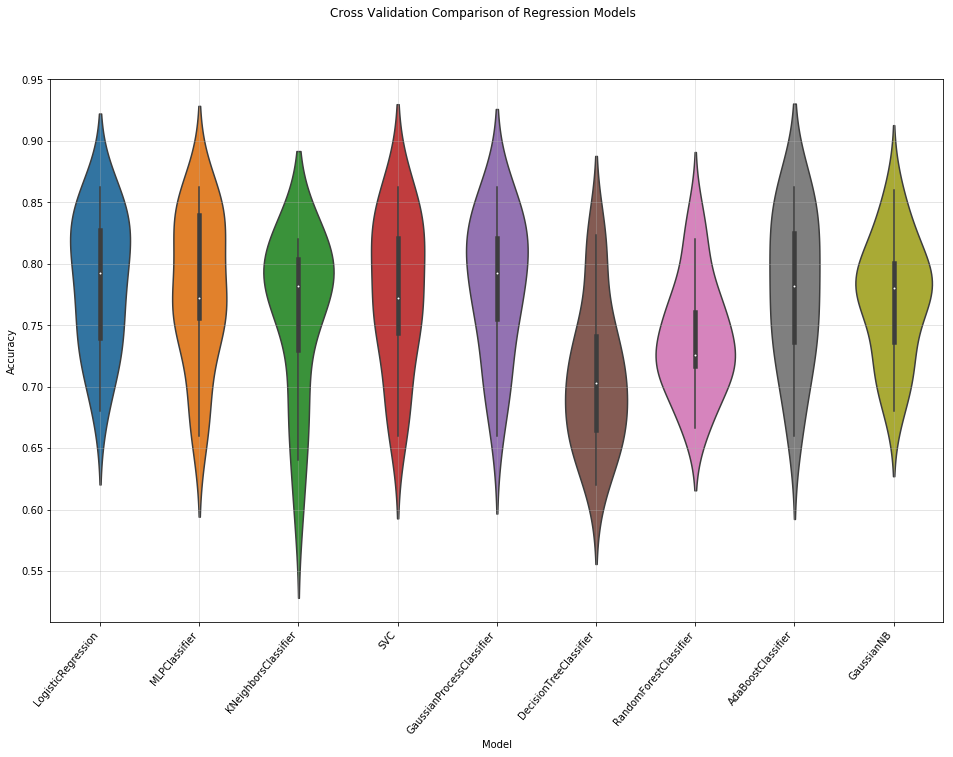

In [23]:
# Initial Cross Validation
models = []
models.append(LogisticRegression())
models.append(MLPClassifier())
models.append(KNeighborsClassifier())
models.append(SVC())
models.append(GaussianProcessClassifier())
models.append(DecisionTreeClassifier())
models.append(RandomForestClassifier())
models.append(AdaBoostClassifier())
models.append(GaussianNB())

class_crossval_plot(X_train, y_train, models, splits=20)

## Choose Model

In [24]:
params = {}
grid = GridSearchCV(LogisticRegression, params, n_jobs=-1)

In [29]:
#test accuracy
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
actual = y_test
correct = 0
for i in range(0, len(pred)):
    if pred[i] == actual[i]:
        correct += 1
correct / len(pred)

0.7857142857142857

## Predict

In [26]:
modelTable2 = pd.DataFrame(columns=model_cols)
teams = seeds[ seeds.Season == 2018 ].TeamID.values
tt_filt2 = tt_reset[ tt_reset.Season == 2018 ]
for a, b in combinations(teams, 2):
    if int(a) < int(b):
        lowID = a
        highID = b
    else:
        lowID = b
        highID = a
    diff2 = tt_filt2[ tt_filt2.TeamID == lowID][model_cols].values - tt_filt2[ tt_filt2.TeamID == highID][model_cols].values
    diff2 = pd.DataFrame(np.append([lowID, highID], diff2).reshape(1, -1), columns=['lowID', 'highID'] + model_cols)
    modelTable2 = modelTable2.append(diff2, ignore_index=True)

modelTable2['lowID'] = modelTable2.lowID.astype(int)
modelTable2['highID'] = modelTable2.highID.astype(int)
modelTable2.set_index(['lowID', 'highID'], inplace=True)

In [30]:
model = LogisticRegression()
model.fit(X, y)
pred_2018 = model.predict_proba(modelTable2)[:,1]
outTable = modelTable2.copy()
outTable['prob'] = pred_2018
for col in model_cols:
    del outTable[col]

In [36]:
model2 = MLPClassifier(hidden_layer_sizes=(1000,1000))
model2.fit(X, y)
pred2_2018 = model2.predict_proba(modelTable2)[:,1]
outTable2 = modelTable2.copy()
outTable2['prob'] = pred2_2018
for col in model_cols:
    del outTable2[col]

In [37]:
outTable.head()

prob
lowID highID          
3163  3376    0.653112
      3199    0.731180
      3208    0.791823
      3181    0.820474
      3378    0.842287

In [38]:
outTable2.head()

prob
lowID highID          
3163  3376    0.602306
      3199    0.695748
      3208    0.770141
      3181    0.830388
      3378    0.876713

# Create Ouput CSV

In [39]:
with open('Submissions/WNCAAoutputLog.csv', 'w') as f:
    f.write('ID,Pred\n')
    for index, row in outTable.iterrows():
        f.write('2018_{}_{},{}\n'.format(index[0], index[1], row['prob']))

In [40]:
with open('Submissions/WNCAAoutputMLP.csv', 'w') as f:
    f.write('ID,Pred\n')
    for index, row in outTable2.iterrows():
        f.write('2018_{}_{},{}\n'.format(index[0], index[1], row['prob']))